# Benchmarking the Robustness of Adversarial Examples (Demo)

> Adversarial example robustness against image scaling process.
>
> ©2020 Spencer Woo - https://github.com/spencerwooo

1. Preparation: load transfer-trained CNN classifier model
2. Benchmark baseline classifier accuracy
3. Perform adversarial attack (FGSM)
4. Use OpenCV to resize adversaries and re-evaluate

In [11]:
import cv2
import foolbox
import foolbox.attacks as fa
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from foolbox.distances import Linf
from matplotlib import rcParams

from utils import utils

CLASS_NAMES = [
  "tench",
  "English springer",
  "cassette player",
  "chain saw",
  "church",
  "French horn",
  "garbage truck",
  "gas pump",
  "golf ball",
  "parachute",
]

model = utils.load_trained_model(
  model_name="resnet",
  model_path="../models/200224_0901_resnet_imagenette.pth",
  class_num=len(CLASS_NAMES),
)
preprocessing = dict(
  mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3
)

# resize image to size 213 * 213
transform = transforms.Compose(
  [transforms.Resize((213, 213)), transforms.ToTensor()]
)

# load dataset with validation images
dataset = torchvision.datasets.ImageFolder(
  root="../data/imagenette2-160/val", transform=transform
)

# get one image for demo purpose
dataset = torch.utils.data.Subset(dataset, [431])
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=1)
dataset_size = len(dataset)

if torch.cuda.is_available():
  model = model.cuda()

fmodel = foolbox.models.PyTorchModel(
  model,
  bounds=(0, 1),
  num_classes=len(CLASS_NAMES),
  preprocessing=preprocessing,
)
rcParams["font.family"] = "monospace"


def img_to_np(img):
  """ Transpose image to viewable format to plot/visualize. """
  return np.transpose(img, (1, 2, 0))


image, label = iter(dataset_loader).next()
print('Loaded image from dataset, ground truth: {}'.format(CLASS_NAMES[label]))

Loaded image from dataset, ground truth: English springer


## Baseline prediction

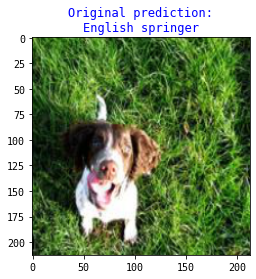

In [12]:
plt.imshow(img_to_np(image.squeeze()))

prob = fmodel.forward(image.numpy())
pred = np.argmax(prob, axis=-1)
plt.title(
  "Original prediction:\n{}".format(CLASS_NAMES[pred[0]]), color="b",
)
plt.show()

## Perform attack

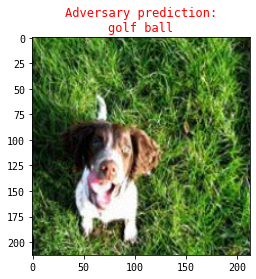

In [13]:
attack = fa.GradientSignAttack(fmodel, distance=Linf)
adv = attack(image.numpy(), label.numpy(), epsilons=[4 / 255])

prob = fmodel.forward(adv)
pred = np.argmax(prob, axis=-1)
plt.imshow(img_to_np(adv.squeeze()))
plt.title(
  "Adversary prediction:\n{}".format(CLASS_NAMES[pred[0]]), color="r",
)
plt.show()

## Resize adversarial examples with OpenCV

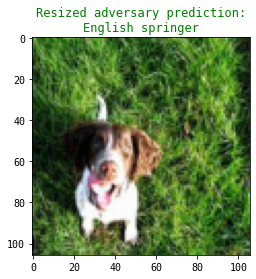

In [14]:
resized_adv = cv2.resize(
  np.moveaxis(adv.squeeze(), 0, 2),
  (0, 0),
  fx=0.5,
  fy=0.5,
  interpolation=cv2.INTER_LINEAR,
)
resized_adv = np.moveaxis(resized_adv, 2, 0)
resized_adv = np.expand_dims(resized_adv, axis=1)

prob = fmodel.forward(resized_adv)
pred = np.argmax(prob, axis=-1)
plt.imshow(img_to_np(resized_adv.squeeze()))
plt.title(
  "Resized adversary prediction:\n{}".format(CLASS_NAMES[pred[0]]), color="g",
)
plt.show()